# Concrete Crack Detection Using Transfer Larning

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
import random
import sys, os
import shutil
from glob import glob
import imageio

## Load the Crack Dataset

- Link to the crack data set:  https://data.mendeley.com/datasets/5y9wdsg2zt/2

In [2]:
# Data from: https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip

--2021-10-07 20:39:01--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.44.250
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.44.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240847944 (230M) [application/octet-stream]
Saving to: ‘5y9wdsg2zt-2.zip’

5y9wdsg2zt-2.zip    100%[===================>] 229.69M  26.5MB/s    in 9.9s    

2021-10-07 20:39:12 (23.3 MB/s) - ‘5y9wdsg2zt-2.zip’ saved [240847944/240847944]



In [3]:
!ls

5y9wdsg2zt-2.zip  sample_data


In [4]:
!unzip -qq -o 5y9wdsg2zt-2.zip

In [5]:
!ls

 5y9wdsg2zt-2.zip  'Concrete Crack Images for Classification.rar'   sample_data


In [6]:
!unrar x 'Concrete Crack Images for Classification.rar'
!ls

Streaming output truncated to the last 5000 lines.
Extracting  Negative/15004.jpg                                            88%  OK 
Extracting  Negative/15005.jpg                                            88%  OK 
Extracting  Negative/15006.jpg                                            88%  OK 
Extracting  Negative/15007.jpg                                            88%  OK 
Extracting  Negative/15008.jpg                                            88%  OK 
Extracting  Negative/15009.jpg                                            88%  OK 
Extracting  Negative/15010.jpg                                            88%  OK 
Extracting  Negative/15011.jpg                                            88%  OK 
Extracting  Negative/15012.jpg                                            88%  OK 
Extracting  Negative/15013.jpg                                            88%  OK 
Extracting  Negative/15014.jp

In [7]:
crack_images = os.listdir('Positive/')
print("Number of Crack Images: ", len(crack_images))

no_crack_images = os.listdir('Negative/')
print("Number of No Crack Images: ", len(no_crack_images))

Number of Crack Images:  20000
Number of No Crack Images:  20000


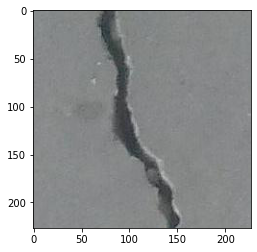

In [8]:
# look at an image for fun
plt.imshow(imageio.imread('Positive/00001.jpg'))
plt.show()

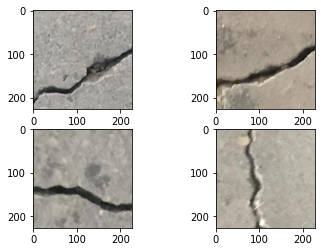

In [10]:
## Visualize Random crack images
random_indices = np.random.randint(0, len(crack_images), size=4)
random_images = np.array(crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(f'Positive/{random_images[0]}'))
axarr[0,1].imshow(mpimg.imread(f'Positive/{random_images[1]}'))
axarr[1,0].imshow(mpimg.imread(f'Positive/{random_images[2]}'))
axarr[1,1].imshow(mpimg.imread(f'Positive/{random_images[3]}'))

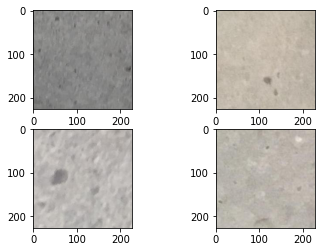

In [11]:
## Visualize Random noncrack images
random_indices = np.random.randint(0, len(no_crack_images), size=4)
random_images = np.array(no_crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(f'Negative/{random_images[0]}'))
axarr[0,1].imshow(mpimg.imread(f'Negative/{random_images[1]}'))
axarr[1,0].imshow(mpimg.imread(f'Negative/{random_images[2]}'))
axarr[1,1].imshow(mpimg.imread(f'Negative/{random_images[3]}'))

## Train and Test Datasets

In [14]:
# remove data if already exist
!rm -r data
# Make directories to store the data Keras-style
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/noncrack
!mkdir data/train/crack
!mkdir data/test/noncrack
!mkdir data/test/crack

In [15]:
# Move the images
# Note: we will consider 'training' to be the train set
#       'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv Negative/* data/train/noncrack
!mv Positive/* data/train/crack
# test set will be generated randomly from train set

crack_train = 'data/train/crack'
crack_test = 'data/test/crack/'
noncrack_train = 'data/train/noncrack/'
noncrack_test = 'data/test/noncrack/'

crack_files = os.listdir(crack_train)
noncrack_files = os.listdir(noncrack_train)

print(f"crack_files:{len(crack_files)}, noncrack_files:{len(noncrack_files)}")

for f in crack_files:
    if random.random() > 0.80:
        shutil.move(f'{crack_train}/{f}', crack_test)

for f in noncrack_files:
    if random.random() > 0.80:
        shutil.move(f'{noncrack_train}/{f}', noncrack_test)

# show the number of train and test images
print(f"Train set: crack={len(os.listdir(crack_train))}, noncrack={len(os.listdir(noncrack_train))}")
print(f"Test set: crack={len(os.listdir(crack_test))}, noncrack={len(os.listdir(noncrack_test))}")

crack_files:20000, noncrack_files:20000
Train set: crack=16080, noncrack=16076
Test set: crack=3920, noncrack=3924


In [16]:
# Note: normalize mmean and std are standardized for ImageNet
# https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet
train_transform = transforms.Compose([
  transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
  transforms.RandomRotation(degrees=15),
  transforms.ColorJitter(),
  transforms.CenterCrop(size=224),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                
])

test_transform = transforms.Compose([
  transforms.Resize(size=256),
  transforms.CenterCrop(size=224),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [17]:
train_dataset = datasets.ImageFolder(
    'data/train',
    transform=train_transform
)
test_dataset = datasets.ImageFolder(
    'data/test',
    transform=test_transform
)

In [18]:
# Data loader
# Usefull because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [19]:
# Define the model
model = models.vgg16(pretrained=True)

# Freeze VGG weights
for param in model.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [20]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
# We want to replace the 'classifier'
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [22]:
n_features = model.classifier[0].in_features
n_features

25088

In [23]:
# We're doing binary classification
model.classifier = nn.Linear(n_features, 2)

In [24]:
# Let's see what the model is now
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
# # Define the model
# class CNN(nn.Module):
#   def __init__(self, K):
#     super(CNN, self).__init__()

#     # define the conv layers
#     self.conv1 = nn.Sequential(
#         nn.Conv2d(3, 32, kernel_size=3, padding=1),
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.Conv2d(32, 32, kernel_size=3, padding=1),
#         nn.ReLU(),
#         nn.BatchNorm2d(32),
#         nn.MaxPool2d(2),
#     )

#     self.conv2 = nn.Sequential(
#         nn.Conv2d(32, 64, kernel_size=3, padding=1),
#         nn.ReLU(),
#         nn.BatchNorm2d(64),
#         nn.Conv2d(64, 64, kernel_size=3, padding=1),
#         nn.ReLU(),
#         nn.BatchNorm2d(64),
#         nn.MaxPool2d(2),
#     )

#     self.conv3 = nn.Sequential(
#         nn.Conv2d(64, 128, kernel_size=3, padding=1),
#         nn.ReLU(),
#         nn.BatchNorm2d(128),
#         nn.Conv2d(128, 128, kernel_size=3, padding=1),
#         nn.ReLU(),
#         nn.BatchNorm2d(128),
#         nn.MaxPool2d(2),
#     )

#     # Useful: https://pytorch.org/docs/stable/nn.html#torch.nn.MaxPool2d
#     # H_out = H_in + 2p - 2 --> p = 1 if H_out = H_in

#     # Easy to calculate output
#     # 32 > 16 >8 > 4

#     # define the linear layers
#     self.fc1 = nn.Linear(128 * 4 * 4, 1024)
#     self.fc2 = nn.Linear(1024, K)

#   def forward(self, x):
#     x = self.conv1(x)
#     x = self.conv2(x)
#     x = self.conv3(x)
#     x = x.view(x.size(0), -1)
#     x = F.dropout(x, p=0.5)
#     x = F.relu(self.fc1(x))
#     x = F.dropout(x, p=0.2)
#     x = self.fc2(x)
#     return x
  

In [26]:
# # Instantiate the model
# model = CNN(K)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [28]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [29]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading

    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")
  return train_losses, test_losses

In [30]:
train_losses, test_losses = batch_gd(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    epochs=6
)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/6, Train Loss: 0.0365, Test Loss: 0.0105, Duration: 0:08:47.185859
Epoch 2/6, Train Loss: 0.0121, Test Loss: 0.0063, Duration: 0:08:41.925517
Epoch 3/6, Train Loss: 0.0135, Test Loss: 0.0053, Duration: 0:08:42.695916
Epoch 4/6, Train Loss: 0.0107, Test Loss: 0.0062, Duration: 0:08:42.016629
Epoch 5/6, Train Loss: 0.0097, Test Loss: 0.0084, Duration: 0:08:42.092295
Epoch 6/6, Train Loss: 0.0092, Test Loss: 0.0066, Duration: 0:08:39.165926


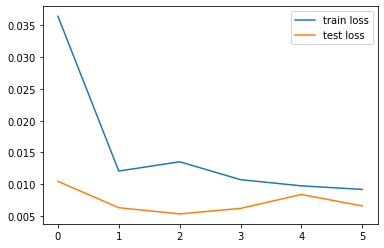

In [31]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [32]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}. Test acc: {test_acc:.4f}")

Train acc: 0.9978. Test acc: 0.9978


# Save and Load Model

In [33]:
# Look at the state dict
model.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3

In [34]:
# Save the model
saved_model_file = 'crack_detection_transfer_learning.pt'
torch.save(model.state_dict(), saved_model_file)

In [35]:
!ls

 5y9wdsg2zt-2.zip				 data	    sample_data
'Concrete Crack Images for Classification.rar'	 Negative
 crack_detection_transfer_learning.pt		 Positive


In [37]:
# Load the model
# Note: this makes more sense and is more compact when
# your model is a big class, as we will be seeing later.

# Define the model
model2 = models.vgg16(pretrained=True)

# Freeze VGG weights
for param in model2.parameters():
  param.requires_grad = False


# We want to replace the 'classifier'
model2.classifier

n_features = model2.classifier[0].in_features
n_features

# We're doing binary classification
model2.classifier = nn.Linear(n_features, 2)

# Let's see what the model is now
print(model2)
model2.load_state_dict(torch.load(saved_model_file))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

<All keys matched successfully>

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model2.to(device)

cuda:0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [39]:
# Evaluate the new model
# Resuls should be the same!

n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model2(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # move data to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model2(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}. Test acc: {test_acc:.4f}")

Train acc: 0.9977. Test acc: 0.9978


In [40]:
# Download the model
from google.colab import files
files.download(saved_model_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Related Work

- [Concrete-Crack-Detection](https://github.com/konskyrt/Concrete-Crack-Detection) 
The model acheived 98% accuracy on the validation set. (Same dataset)